In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql import functions as F
from pyspark.sql.types import *

from pyspark.ml.feature import RFormula, RFormulaModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.feature import StandardScalerModel, MinMaxScalerModel

from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.regression import AFTSurvivalRegressionModel

import os
import sys
import re
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath('/shared/project/')
DATA_DIR = ROOT_DIR + '/data/CMAPSSData/'
AFT_DIR  = ROOT_DIR + '/aft/'
MODEL_DIR = ROOT_DIR + '/aft/models/'

sys.path.append(ROOT_DIR)
import engine_util
import engine_viz


In [2]:
# Create session and context
spark = SparkSession.builder \
    .appName("AFTInference") \
    .getOrCreate()
    
sc = spark.sparkContext
sqlContext = SQLContext(sc)

### Load models

In [3]:

aft_model = AFTSurvivalRegressionModel.load(MODEL_DIR+'aft')
formula_model = RFormulaModel.load(MODEL_DIR+'formula')
scaler_model = MinMaxScalerModel.load(MODEL_DIR+'scaler')

### Data Preparation


In [4]:

schema, feature_cols, label_cols = engine_util.create_engine_schema()
cn = engine_util.CleanData(schema, feature_cols)

In [5]:
# Load the data file. Note if we attempt to apply the schema, the rows 
# with corrupt entries will be set to null. To attempt to preserve them
# the CleanData Estimator will process the data.

data_set_unit = 'FD002'

df_test_x = spark.read.format("csv")\
    .option("delimiter", " ")\
    .option("header", "false")\
    .load(DATA_DIR+'test_'+data_set_unit+'.txt', inferSchema=True)\
    .drop('_c26').drop('_c27')

# Fix the dataframe schema

df_test_x = cn.fit(df_test_x)

print("test_x")
df_test_x.show(5)


test_x
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.2405|0.02|364.0|2324.0|100.0|24.29|14.8039|
|  1|    3| 35.0045|    0.84|   100.0|449.44| 556.0|1359.08|1128.36| 5.48

In [6]:
# Load the data file. Note if we attempt to apply the schema, the rows 
# with corrupt entries will be set to null. To attempt to preserve them
# the CleanData Estimator will process the data.

df_test_y = spark.read.format("csv")\
    .option("delimiter", ",")\
    .option("header", "false")\
    .load(DATA_DIR+'RUL_'+data_set_unit+'.txt', inferSchema=True)


# Add id for each engine
df_test_y = df_test_y\
            .withColumn('engine_id', F.monotonically_increasing_id()+1)

# Fix type and column name 
test_y_schema = StructType()\
   .add("rul", IntegerType())\
   .add("engine_id", IntegerType())

cn_test_y = engine_util.CleanData(test_y_schema)
df_test_y = cn_test_y.fit(df_test_y).select('engine_id', 'rul')

print("test_y")
df_test_y.show(5)

test_y
+---------+---+
|engine_id|rul|
+---------+---+
|        1| 18|
|        2| 79|
|        3|106|
|        4|110|
|        5| 15|
+---------+---+
only showing top 5 rows



This test data was originally used to evaluate the contestant and was not known. The RUL in test_y specifies the RUL at the last cycle of test data. The RUL column we will add will end at the test_y value.

In [7]:
df_test_x.cache()
df_test_x.createOrReplaceTempView('test_x')

df_test_y.createOrReplaceTempView('test_y')
df_test_y.cache()

test_x_cycles_df = df_test_x\
    .groupBy('id')\
    .count()\
    .orderBy( F.asc('id'))\
    .select( F.col('id').alias('cycle_engine_id'), F.col('count').alias('cycles'))


# Number of cycles plus the RUL is the starting RUL of the test data
test_x_cycles_df = test_x_cycles_df\
                    .join(df_test_y, test_x_cycles_df['cycle_engine_id'] == df_test_y['engine_id'])\
                    .drop( F.col('cycle_engine_id'))\
                    .select('engine_id', (F.col('cycles')+F.col('rul')).alias('rul'))

test_x_cycles_df.show(5)     

+---------+---+
|engine_id|rul|
+---------+---+
|        1|276|
|        2|134|
|        3|271|
|        4|196|
|        5|163|
+---------+---+
only showing top 5 rows



In [8]:
num_test_engines = test_x_cycles_df.count()
num_test_engines

259

In [9]:
df_test_x.show(5)


+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.2405|0.02|364.0|2324.0|100.0|24.29|14.8039|
|  1|    3| 35.0045|    0.84|   100.0|449.44| 556.0|1359.08|1128.36| 5.48|  8.0|

In [10]:

j_exp = df_test_x['id'] == test_x_cycles_df['engine_id']

# Join on the engine id then delete the duplicate column
df_test_x = df_test_x\
                .join( test_x_cycles_df, j_exp)\
                .drop( F.col('engine_id'))\
                .withColumn("rul", F.col('rul')-F.col('cycle'))\
                .orderBy( F.asc('id'), F.asc('cycle'))

df_test_x.show(31)


+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|275|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.2405|0.02|364.0|2324.0|100.0|24.29|14.8039|274|
|  1|    3| 35.0045|    0.84|   100.0|449.44| 556.0|1359.08|

In [11]:

test_preparedDF = formula_model.transform(df_test_x)
test_preparedDF.show(5)

test_scaledData = scaler_model.transform(test_preparedDF)
test_scaledData.show(5)

+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+--------------------+-----+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|            features|label|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+--------------------+-----+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|275|[1.0,9.9987001419...|275.0|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.

### Run inference

In [12]:

pred_test = aft_model.transform(test_scaledData)

pred_rmse = engine_util.calc_rmse(pred_test)
print("RMSE: ", pred_rmse)

RMSE:  50.01015192833228


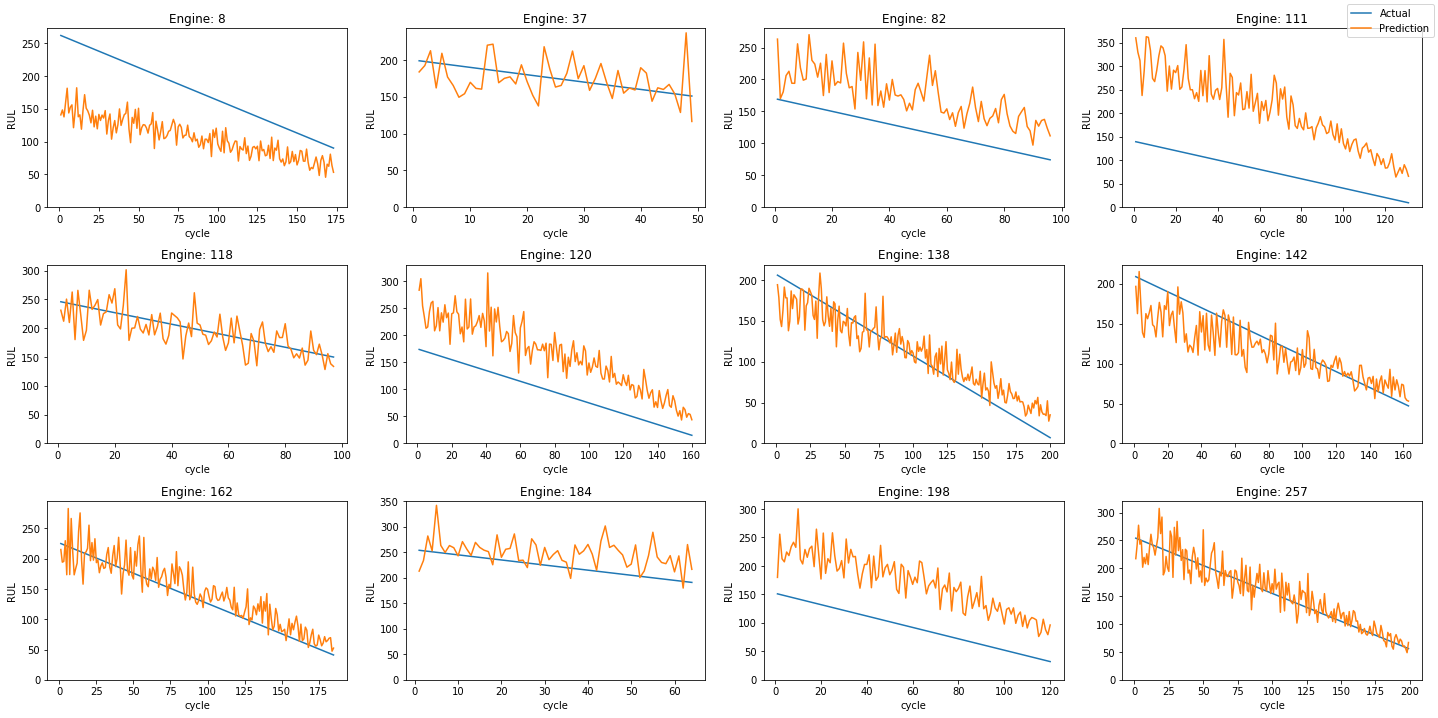

In [13]:
# Select 10 engines at random

engine_ids = random.sample(range(1,num_test_engines+1), 12)
engine_viz.display_engine_prediction(engine_ids, pred_test)